# Make netcdf files of tas and pr for all warming levels based on best subset cmip6 data
### dimensions should be warming level, lat, lon

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import dask
import time
import matplotlib.pyplot as plt
from warming_years import get_cmip6_data_at_warming_years

In [2]:
# Data can be based on either the moving window approach (e.g. 21 year moving window) or the temperature window approach (e.g. +/-0.25C window)
warming_year_type = 'temperature_window' #'moving_window' # 'temperature_window'

cmip6_variable = 'pr'
year_window = 0
warm_levs = ['1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5']
outdir = '/home/abbylute/alute_bucket/warming_levels/data/warming_year_aggregated_data/'
#outfile = outdir + cmip6_variable + '/' + cmip6_variable + '_aggregated_at_warming_levels_21yr_window.nc'
outfile = outdir + cmip6_variable + '/' + cmip6_variable + '_aggregated_at_warming_levels_0.5C_window.nc'


In [3]:
# create new common grid to interpolate to
newlats = np.arange(-90, 90.01, .5)
newlons = np.arange(-180, 180, .5)

In [4]:
# to remove warnings about chunk sizes
dask.config.set(**{'array.slicing.split_large_chunks': False})

In [5]:
# for each warming level, pull in the cmip6 data

t0 = time.time()

if warming_year_type == 'moving_window':
    
    
    # Load table of best subset 21 year window warming years
    tab = pd.read_csv('/home/abbylute/alute_bucket/warming_levels/data/warming_year_tables/warming_years_zarr_21yr_window_best_set.csv')

    # remove model/member/scenario combinations that are available for tas (thus are in the warming year table) but aren't available for pr
    if cmip6_variable == 'pr':
        notavailable = tab.loc[(tab['model']=='NorESM2-LM') & (tab['member']=='r1i1p1f1') & (tab['scenario']=='ssp585')]
        tab = tab.drop(notavailable.index)
        notavailable = tab.loc[(tab['model']=='ACCESS-ESM1-5') & (tab['member']=='r31i1p1f1') & (tab['scenario']=='ssp585')]
        tab = tab.drop(notavailable.index)

    for wl in warm_levs:
        print('running warming level ' + wl)
        i = 0

        for r in range(tab.shape[0]):
            tab0 = tab.iloc[r,:]
            warming_years = tab0['Yr' + str(float(wl))]

            # if the warming year for this model/member/scenario is not reach (is nan), then skip to the next one
            # otherwise:
            if ~np.isnan(warming_years):
                i = i+1
                dat = get_cmip6_data_at_warming_years(tab0.model, tab0.member, tab0.scenario, cmip6_variable, warming_years=warming_years, year_window=year_window, outfilename=None)

                # there is only one member per model, so we can get rid of the member dimension
                dat = dat.mean('member')

                # interpolate to common spatial grid
                dat = dat.interp(lon=newlons, lat=newlats, method="linear")

                # remove lat and lon bounds since not all datasets have these variables, and we changed the lat and lon anyway
                dat = dat.drop(['lat_bnds','lon_bnds','bnds'], errors='ignore')

                if i==1:
                    xout = dat
                else:
                    xout = xr.concat([xout, dat], dim='scenario')
        
        # aggregate
        xout = xout.mean(['scenario','model','year'])
    
        # add a warming level dimension
        xout = xout.assign_coords(warming_level=float(wl)).expand_dims('warming_level')
    
        if wl == warm_levs[0]:
            xwl = xout
        else:
            xwl = xr.concat([xwl, xout], dim='warming_level')

            
elif warming_year_type == 'temperature_window':
    
    
    for wl in warm_levs:
        print('running warming level ' + wl)
    
        # Load table of best subset warming years
        tab = pd.read_csv('/home/abbylute/alute_bucket/warming_levels/data/warming_year_tables/warming_years_zarr_0.5C_window_' + wl + 'C_wl_best_set.csv')
    
        # remove model/member/scenario combinations that are available for tas (thus are in the warming year table) but aren't available for pr
        if cmip6_variable == 'pr':
            notavailable = tab.loc[(tab['model']=='NorESM2-LM') & (tab['member']=='r1i1p1f1') & (tab['scenario']=='ssp585')]
            tab = tab.drop(notavailable.index)
            notavailable = tab.loc[(tab['model']=='ACCESS-ESM1-5') & (tab['member']=='r31i1p1f1') & (tab['scenario']=='ssp585')]
            tab = tab.drop(notavailable.index)

        mms = tab[['model','member','scenario']].loc[tab['scenario']!='historical'].drop_duplicates()
    
        i = 0

        for r in range(mms.shape[0]):
            mod = mms['model'].iloc[r]
            mem = mms['member'].iloc[r]
            scen = mms['scenario'].iloc[r]
            tab0 = tab.loc[(tab['model']==mod) & (tab['member']==mem) & (tab['scenario'].isin([scen,'historical']))]

            warming_years = np.unique(tab0.year.values)

            # if the warming year for this model/member/scenario is not reach (is nan), then skip to the next one
            # otherwise:
            if ~np.isnan(warming_years).all():
                i = i+1
                dat = get_cmip6_data_at_warming_years(mod, mem, scen, cmip6_variable, warming_years=warming_years, year_window=year_window, outfilename=None)

                # there is only one member per model, so we can get rid of the member dimension
                dat = dat.mean('member')

                # interpolate to common spatial grid
                dat = dat.interp(lon=newlons, lat=newlats, method="linear")

                # remove lat and lon bounds since not all datasets have these variables, and we changed the lat and lon anyway
                dat = dat.drop(['lat_bnds','lon_bnds','bnds'], errors='ignore')

                if i==1:
                    xout = dat
                else:
                    xout = xr.concat([xout, dat], dim='scenario')
        
        # aggregate
        xout = xout.mean(['scenario','model','year'])
    
        # add a warming level dimension
        xout = xout.assign_coords(warming_level=float(wl)).expand_dims('warming_level')
    
        if wl == warm_levs[0]:
            xwl = xout
        else:
            xwl = xr.concat([xwl, xout], dim='warming_level')
    

t1 = time.time()
print('elapsed time: ' + str((t1-t0)/60) + ' minutes')
xwl

running warming level 1


/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/dask/array/core.py:4465: PerformanceWarning: Increasing number of chunks by factor of 11
  **blockwise_kwargs,
/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/dask/array/core.py:4465: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/dask/array/core.py:4465: PerformanceWarning: Increasing number of chunks by factor of 19
  **blockwise_kwargs,
/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/dask/array/core.py:4465: PerformanceWarning: Increasing number of chunks by factor of 23
  **blockwise_kwargs,
/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/dask/array/core.py:4465: PerformanceWarning: Increasing number of chunks by factor of 27
  **blockwise_kwargs,
/home/abbylute/miniconda3/envs/warming_levels-env/lib/p

running warming level 1.5


/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  zz['time'] = zz.indexes['time'].to_datetimeindex()
/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  zz['time'] = zz.indexes['time'].to_datetimeindex()
/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, wh

running warming level 2


/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  zz['time'] = zz.indexes['time'].to_datetimeindex()
/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  zz['time'] = zz.indexes['time'].to_datetimeindex()
/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, wh

running warming level 2.5


/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  zz['time'] = zz.indexes['time'].to_datetimeindex()
/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  zz['time'] = zz.indexes['time'].to_datetimeindex()
/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, wh

running warming level 3


/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  zz['time'] = zz.indexes['time'].to_datetimeindex()
/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  zz['time'] = zz.indexes['time'].to_datetimeindex()
/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing usin

running warming level 3.5


/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  zz['time'] = zz.indexes['time'].to_datetimeindex()
/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  zz['time'] = zz.indexes['time'].to_datetimeindex()
/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing usin

running warming level 4


/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  zz['time'] = zz.indexes['time'].to_datetimeindex()
/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out 

running warming level 4.5


/home/abbylute/alute_bucket/warming_levels/code/Warming_levels/warming_years.py:271: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  zz['time'] = zz.indexes['time'].to_datetimeindex()
/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/abbylute/miniconda3/envs/warming_levels-env/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out 

elapsed time: 29.40171444416046 minutes


<xarray.Dataset>
Dimensions:        (warming_level: 8, lat: 361, lon: 720)
Coordinates:
  * lon            (lon) float64 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
  * lat            (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * warming_level  (warming_level) float64 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5
Data variables:
    pr             (warming_level, lat, lon) float64 dask.array<chunksize=(1, 361, 720), meta=np.ndarray>

In [6]:
# save the file
xwl.to_netcdf(outfile) # This took 2+ hours to save

In [7]:
# check the saved file
xwl = xr.open_dataset(outfile)
xwl

<xarray.Dataset>
Dimensions:        (warming_level: 8, lat: 361, lon: 720)
Coordinates:
  * lon            (lon) float64 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
  * lat            (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * warming_level  (warming_level) float64 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5
Data variables:
    pr             (warming_level, lat, lon) float64 ...

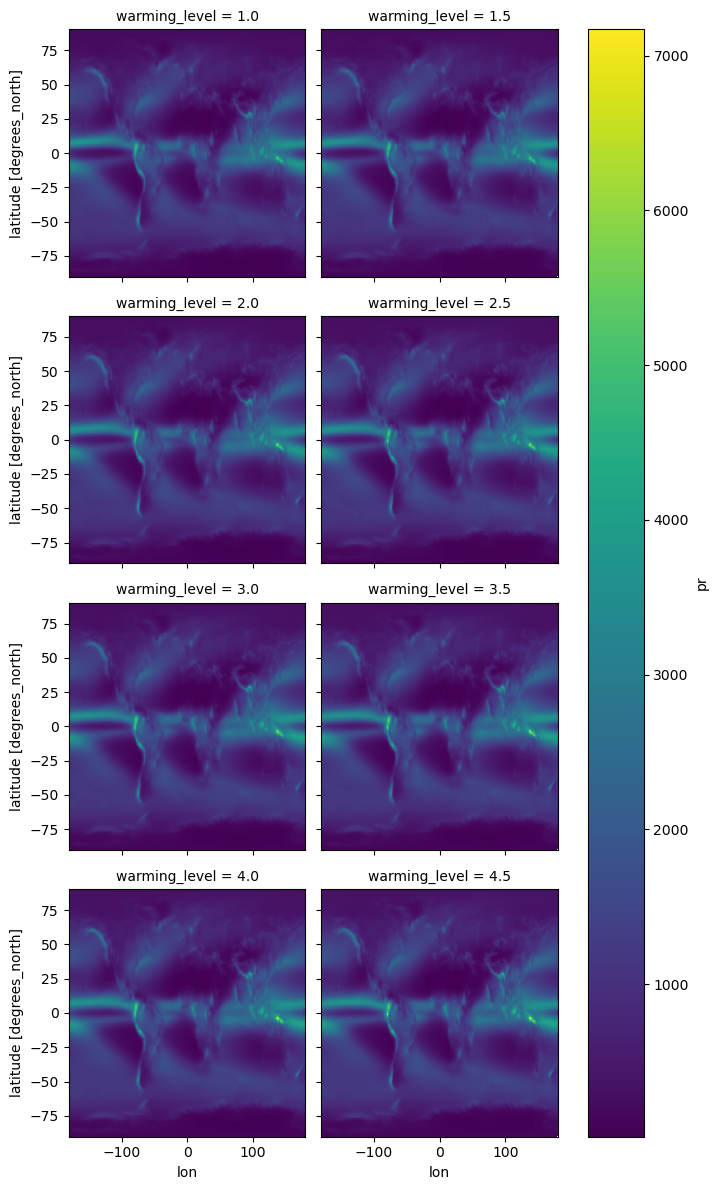

In [8]:

xwl[cmip6_variable].plot(col='warming_level', col_wrap=2)


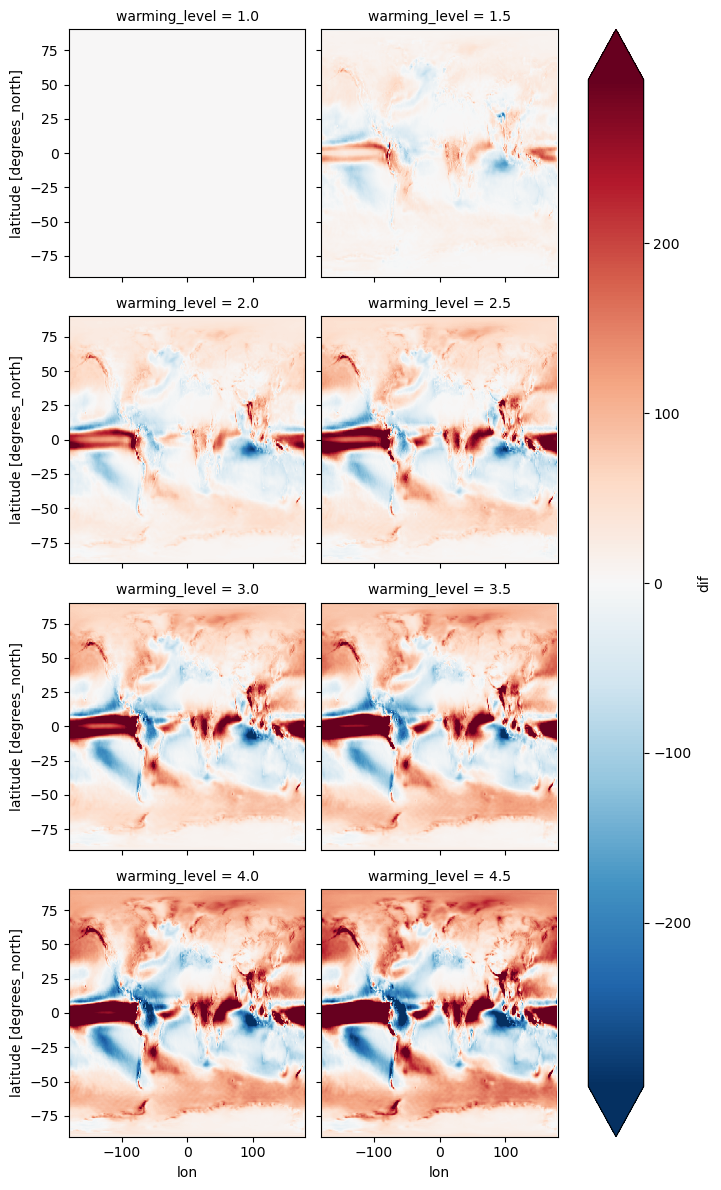

In [9]:
xwl['dif'] = xwl[cmip6_variable] - xwl[cmip6_variable].isel(warming_level=0)
xwl.dif.plot(col='warming_level',col_wrap=2, robust=True)